## BERTMultilingual on tweets and comments without any preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch, random

filepath_train = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train.csv'
filepath_test = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev.csv'

df_train = pd.read_csv(filepath_train, header=0).dropna()
df_test = pd.read_csv(filepath_test, header=0).dropna()

def set_seed(seed_value=42):
    """Set seed for reproducibility for PyTorch and NumPy.

    Args:
        seed_value (int): The seed value to set for random number generators.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Additional steps for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
aggression_dict = {'CAG':0, 'NAG':1, 'OAG':2}

x_train = df_train['text']
y_train = df_train['class'].apply(lambda key: aggression_dict[key])

# https://datascience.stackexchange.com/a/15136
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify = y_train)

x_test = df_test['text']
y_test = df_test['class'].apply(lambda key: aggression_dict[key])

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

# Load the tokenizer and model
from datasets import Dataset
def create_dataset(inputs, targets):
    # Throw error if number of comments/tweets is not equal to number of labels
    assert len(inputs) == len(targets)

    # inputs = [input.lower() for input in inputs]
    dataset_dict = {"input_text": inputs, "targets": targets}

    # Create a huggingface dataset from dictionary
    dataset = Dataset.from_dict(dataset_dict)

    # Tokenize the data into 1-hot encoded values for inputs
    def tokenize_and_encode(examples):
        inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        return {"input_ids": inputs.input_ids, "attention_mask": inputs.attention_mask, "labels": examples["targets"]}

    dataset = dataset.map(tokenize_and_encode, batched=True, batch_size=2)
    return dataset

# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    save_steps=1000,                 # number of updates steps before checkpoint saves
    save_total_limit=2,              # limit the total amount of saved checkpoints
    logging_steps=10,                # print losses after 10 steps
    learning_rate=0.000001
)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_data = create_dataset(x_train, y_train)
validation_data = create_dataset(x_val, y_val)

trainer = Trainer(
    model=model,                      # the instantiated 🤗 Transformers model to be trained
    args=training_args,               # training arguments, defined above
    train_dataset=train_data,         # training dataset
    eval_dataset=validation_data
)
trainer.train()

# Save the model after training
model_path = "./fine_tuned_bert_classification"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Step,Training Loss
10,1.062200
20,1.065900
30,1.041800
40,1.040700
50,1.000700
60,1.050800
70,1.041900
80,1.071600
90,1.053900
100,1.089300


('./fine_tuned_bert_classification/tokenizer_config.json',
 './fine_tuned_bert_classification/special_tokens_map.json',
 './fine_tuned_bert_classification/vocab.txt',
 './fine_tuned_bert_classification/added_tokens.json')

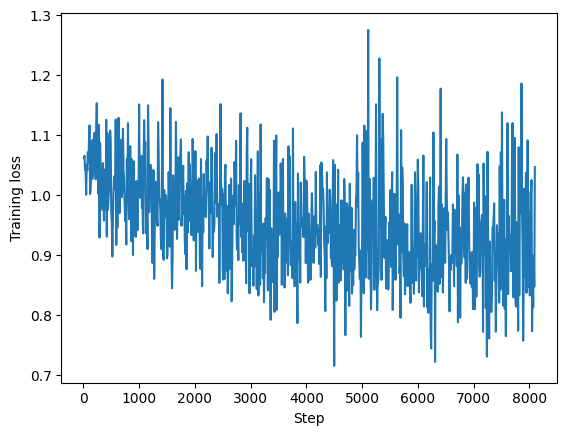

In [ ]:
loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
step = [log['step'] for log in trainer.state.log_history if 'step' in log][:-1]

import matplotlib.pyplot as plt
plt.plot(step, loss)
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.show()

In [ ]:
# Empty VRAM
del model
del trainer

# Invoke garbage collector
import gc
gc.collect()
gc.collect()

0

In [ ]:
from transformers import pipeline

model_path = "./fine_tuned_bert_classification"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
classifier = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

tokenizer_kwargs = {'truncation':True,'max_length':128}
outputs = classifier(list(x_test), **tokenizer_kwargs)

from sklearn.metrics import classification_report
y_pred = [int(output['label'][-1]) for output in outputs]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.51      0.60      0.55      1246
           1       0.60      0.45      0.51       538
           2       0.55      0.52      0.53      1217

    accuracy                           0.54      3001
   macro avg       0.55      0.52      0.53      3001
weighted avg       0.54      0.54      0.54      3001



# Fine-tuning with MLM objective

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
import random
import torch
import numpy as np

def set_seed(seed_value=42):
    """Set seed for reproducibility for PyTorch and NumPy.

    Args:
        seed_value (int): The seed value to set for random number generators.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Additional steps for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)  # You can replace 42 with any other seed value of your choice

In [ ]:
from transformers import TFAutoModelForMaskedLM, AutoTokenizer

# Load the tokenizer and model
model_checkpoint = "bert-base-multilingual-uncased"
model = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset
import pandas as pd
import torch

def create_dataset(filepath):
    def tokenize(inputs):
      result = tokenizer(inputs['text'])
      if tokenizer.is_fast:
          result['word_ids'] = [result.word_ids(i) for i in range(len(result['input_ids']))]
      return result

    def group_texts(inputs):
      concatenated = {k: sum(inputs[k], []) for k in inputs.keys()}

      chunk_size = 128
      total_length = len(concatenated[list(inputs.keys())[0]])
      total_length = (total_length // chunk_size) * chunk_size # We drop the last chunk if it's smaller than chunk_size
      result = {
          k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
          for k, t in concatenated.items()
      }

      result['labels'] = result['input_ids'].copy()
      return result

    inputs = pd.read_csv(filepath, sep='\t', header=0, usecols=['cs_query']).rename(columns={'cs_query':'text'})
    input_dataset = Dataset.from_pandas(inputs).train_test_split(test_size=0.1)
    tokenized_dataset = input_dataset.map(tokenize, batched=True, remove_columns=['text'])
    dataset = tokenized_dataset.map(group_texts, batched=True)
    return dataset


hinglish_data = create_dataset("/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/Hinglish-TOP.tsv")
hinglish_data

Map:   0%|          | 0/153074 [00:00<?, ? examples/s]

Map:   0%|          | 0/17009 [00:00<?, ? examples/s]

Map:   0%|          | 0/153074 [00:00<?, ? examples/s]

Map:   0%|          | 0/17009 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 17168
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1908
    })
})

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15, return_tensors="tf")

train_dataset = model.prepare_tf_dataset(
    hinglish_data["train"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)

test_dataset = model.prepare_tf_dataset(
    hinglish_data["test"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=32,
)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import create_optimizer
from transformers.keras_callbacks import PushToHubCallback
import tensorflow as tf

num_train_steps = len(train_dataset)
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=1_000,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

model_name = model_checkpoint.split("/")[-1]
callback = PushToHubCallback(
    output_dir=f"{model_name}-finetuned-hinglish", tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/krishnasri/bert-base-multilingual-uncased-finetuned-hinglish into local empty directory.


In [ ]:
import math
eval_loss = model.evaluate(test_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

60/60 [==============================] - 31s 520ms/step - loss: 5.5039
Perplexity: 245.65


In [ ]:
model.fit(train_dataset, validation_data=test_dataset, callbacks=[callback])
eval_loss = model.evaluate(test_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

60/60 [==============================] - 32s 530ms/step - loss: 1.9355
Perplexity: 6.93


# Finetuning for aggression classification - plain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

filepath_train = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train.csv'
filepath_test = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev.csv'

df_train = pd.read_csv(filepath_train, header=0).dropna()
df_test = pd.read_csv(filepath_test, header=0).dropna()

df_train.head()

,id,text,class
0,facebook_corpus_msr_401470,Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu...,OAG
1,facebook_corpus_msr_386695,Bhai 60sal pehle desh me kya tha pehle pta kro...,CAG
2,facebook_corpus_msr_373389,chutiya friday ko isliye releae krte kyoki wee...,CAG
3,facebook_corpus_msr_917635,जय मोदीराज,CAG
4,facebook_corpus_msr_382517,UPA walo ne bahot kuch kr diya tha desh k liye,CAG


In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00


In [ ]:
aggression_dict = {'CAG':0, 'NAG':1, 'OAG':2}

x_train = df_train['text']
y_train = df_train['class'].apply(lambda key: aggression_dict[key])

# https://datascience.stackexchange.com/a/15136
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify = y_train)

x_test = df_test['text']
y_test = df_test['class'].apply(lambda key: aggression_dict[key])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the tokenizer and model
model_checkpoint = "krishnasri/bert-base-multilingual-uncased-finetuned-hinglish"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3, from_tf=True)

# Load the tokenizer and model
from datasets import Dataset
def create_dataset(inputs, targets):
    # Throw error if number of comments/tweets is not equal to number of labels
    assert len(inputs) == len(targets)

    # inputs = [input.lower() for input in inputs]
    dataset_dict = {"input_text": inputs, "targets": targets}

    # Create a huggingface dataset from dictionary
    dataset = Dataset.from_dict(dataset_dict)

    # Tokenize the data into 1-hot encoded values for inputs
    def tokenize_and_encode(examples):
        inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        return {"input_ids": inputs.input_ids, "attention_mask": inputs.attention_mask, "labels": examples["targets"]}

    dataset = dataset.map(tokenize_and_encode, batched=True, batch_size=2)
    return dataset

# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    save_steps=1000,                 # number of updates steps before checkpoint saves
    save_total_limit=2,              # limit the total amount of saved checkpoints
    logging_steps=10,                # print losses after 10 steps
    learning_rate=0.0000005
)

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/997M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
train_data = create_dataset(x_train, y_train)
validation_data = create_dataset(x_val, y_val)

trainer = Trainer(
    model=model,                      # the instantiated 🤗 Transformers model to be trained
    args=training_args,               # training arguments, defined above
    train_dataset=train_data,         # training dataset
    eval_dataset=validation_data
)
trainer.train()

# Save the model after training
model_path = "./fine_tuned_bert_classification"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Step,Training Loss
10,1.078000
20,1.088100
30,1.065500
40,1.065900
50,1.049500
60,1.082800
70,1.056300
80,1.081100
90,1.088800
100,1.061500


('./fine_tuned_bert_classification/tokenizer_config.json',
 './fine_tuned_bert_classification/special_tokens_map.json',
 './fine_tuned_bert_classification/vocab.txt',
 './fine_tuned_bert_classification/added_tokens.json',
 './fine_tuned_bert_classification/tokenizer.json')

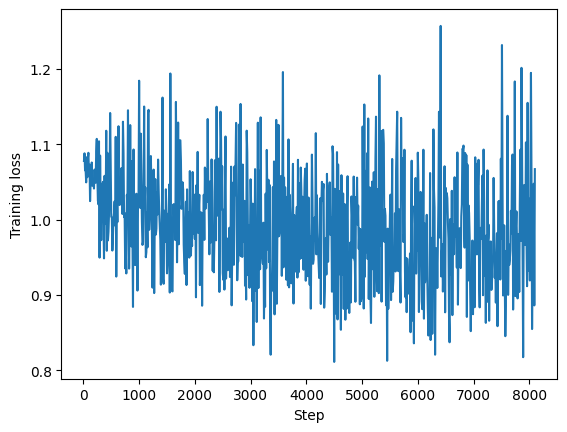

In [ ]:
loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
step = [log['step'] for log in trainer.state.log_history if 'step' in log][:-1]

import matplotlib.pyplot as plt
plt.plot(step, loss)
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.show()

In [ ]:
# Empty VRAM
del model
del trainer

# Invoke garbage collector
import gc
gc.collect()
gc.collect()

0

In [ ]:
from transformers import pipeline

model_path = "./fine_tuned_bert_classification"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
classifier = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

tokenizer_kwargs = {'truncation':True,'max_length':256}
outputs = classifier(list(x_test), **tokenizer_kwargs)

from sklearn.metrics import classification_report
y_pred = [int(output['label'][-1]) for output in outputs]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.48      0.52      0.50      1246
           1       0.61      0.36      0.46       538
           2       0.50      0.55      0.53      1217

    accuracy                           0.50      3001
   macro avg       0.53      0.48      0.49      3001
weighted avg       0.51      0.50      0.50      3001



# Transliterating TRAC-extended data using indic-trans library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/libindic/indic-trans.git

!pip install -r indic-trans/requirements.txt
!pip install indic-trans/.

fatal: destination path 'indic-trans' already exists and is not an empty directory.
Processing ./indic-trans
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for indictrans: filename=indictrans-1.2.3-cp310-cp310-linux_x86_64.whl size=337822734 sha256=d2d1b1c33ae78bd0d73b3e8983f42b7ad0b501b1ff02176f1a0ebaef49d11fb5
  Stored in directory: /root/.cache/pip/wheels/3e/c9/43/39c5aaa9a570043089bac219a37343294fa5b47f1350dea53a
Successfully built indictrans


In [ ]:
import pandas as pd

filepath_train = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train.csv'
filepath_test = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev.csv'

df_train = pd.read_csv(filepath_train, names=['id', 'text', 'class']).dropna()
df_test = pd.read_csv(filepath_test, names=['id', 'text', 'class']).dropna()

In [ ]:
df_train.head(n=10)

,id,text,class
0,facebook_corpus_msr_401470,Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu...,OAG
1,facebook_corpus_msr_386695,Bhai 60sal pehle desh me kya tha pehle pta kro...,CAG
2,facebook_corpus_msr_373389,chutiya friday ko isliye releae krte kyoki wee...,CAG
3,facebook_corpus_msr_917635,जय मोदीराज,CAG
4,facebook_corpus_msr_382517,UPA walo ne bahot kuch kr diya tha desh k liye,CAG
5,facebook_corpus_msr_403274,Pan ko Aadhar se link ki zarurat kuy hai? Supr...,CAG
6,facebook_corpus_msr_1723083,काकर पाथर जोड़ के मस्जिद लई बनाय।\n\nता चढ़ि मुल...,OAG
7,facebook_corpus_msr_325257,Us raat tere papa k jageh mera sperm gya tha u...,OAG
8,facebook_corpus_msr_23447,गटर के कीड़े,OAG
9,facebook_corpus_msr_1477104,Waise bandhu jet lag se bachne ke liye Raat ko...,NAG


In [ ]:
from indictrans import Transliterator
trn = Transliterator(source='hin', target='eng', build_lookup=True)

In [ ]:
df_train['text'] = df_train['text'].apply(trn.transform)
df_train.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train_translit.csv', encoding='utf-8', escapechar='\\', index=False)

In [ ]:
df_test['text'] = df_test['text'].apply(trn.transform)
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev_translit.csv', encoding='utf-8', escapechar='\\', index=False)

# Finetuning for aggression classification - transliterated

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

filepath_train = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train_translit.csv'
filepath_test = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev_translit.csv'

df_train = pd.read_csv(filepath_train, header=0).dropna()
df_test = pd.read_csv(filepath_test, header=0).dropna()

df_train.head()

,id,text,class
0,facebook_corpus_msr_401470,Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu...,OAG
1,facebook_corpus_msr_386695,Bhai 60sal pehle desh me kya tha pehle pta kro...,CAG
2,facebook_corpus_msr_373389,chutiya friday ko isliye releae krte kyoki wee...,CAG
3,facebook_corpus_msr_917635,jai modiraj,CAG
4,facebook_corpus_msr_382517,UPA walo ne bahot kuch kr diya tha desh k liye,CAG


In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00


In [ ]:
aggression_dict = {'CAG':0, 'NAG':1, 'OAG':2}

x_train = df_train['text']
y_train = df_train['class'].apply(lambda key: aggression_dict[key])

# https://datascience.stackexchange.com/a/15136
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify = y_train)

x_test = df_test['text']
y_test = df_test['class'].apply(lambda key: aggression_dict[key])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the tokenizer and model
model_checkpoint = "krishnasri/bert-base-multilingual-uncased-finetuned-hinglish"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3, from_tf=True)

# Load the tokenizer and model
from datasets import Dataset
def create_dataset(inputs, targets):
    # Throw error if number of comments/tweets is not equal to number of labels
    assert len(inputs) == len(targets)

    # inputs = [input.lower() for input in inputs]
    dataset_dict = {"input_text": inputs, "targets": targets}

    # Create a huggingface dataset from dictionary
    dataset = Dataset.from_dict(dataset_dict)

    # Tokenize the data into 1-hot encoded values for inputs
    def tokenize_and_encode(examples):
        inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        return {"input_ids": inputs.input_ids, "attention_mask": inputs.attention_mask, "labels": examples["targets"]}

    dataset = dataset.map(tokenize_and_encode, batched=True, batch_size=2)
    return dataset

# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    save_steps=1000,                 # number of updates steps before checkpoint saves
    save_total_limit=2,              # limit the total amount of saved checkpoints
    logging_steps=10,                # print losses after 10 steps
    learning_rate=0.0000005
)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
train_data = create_dataset(x_train, y_train)
validation_data = create_dataset(x_val, y_val)

trainer = Trainer(
    model=model,                      # the instantiated 🤗 Transformers model to be trained
    args=training_args,               # training arguments, defined above
    train_dataset=train_data,         # training dataset
    eval_dataset=validation_data
)
trainer.train()

# Save the model after training
model_path = "./fine_tuned_bert_classification"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Step,Training Loss
10,1.076900
20,1.086400
30,1.061700
40,1.067900
50,1.046500
60,1.083100
70,1.051600
80,1.077700
90,1.093900
100,1.067300


('./fine_tuned_bert_classification/tokenizer_config.json',
 './fine_tuned_bert_classification/special_tokens_map.json',
 './fine_tuned_bert_classification/vocab.txt',
 './fine_tuned_bert_classification/added_tokens.json',
 './fine_tuned_bert_classification/tokenizer.json')

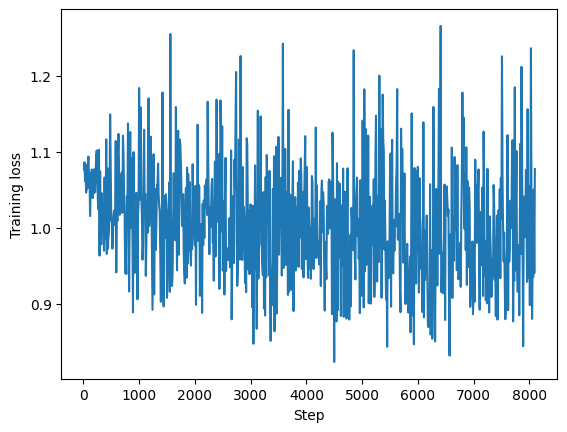

In [ ]:
loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
step = [log['step'] for log in trainer.state.log_history if 'step' in log][:-1]

import matplotlib.pyplot as plt
plt.plot(step, loss)
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.show()

In [ ]:
# Empty VRAM
del model
del trainer

# Invoke garbage collector
import gc
gc.collect()
gc.collect()

0

In [ ]:
from transformers import pipeline

model_path = "./fine_tuned_bert_classification"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
classifier = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

tokenizer_kwargs = {'truncation':True,'max_length':256}
outputs = classifier(list(x_test), **tokenizer_kwargs)

from sklearn.metrics import classification_report
y_pred = [int(output['label'][-1]) for output in outputs]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.48      0.54      0.51      1246
           1       0.62      0.27      0.38       538
           2       0.47      0.52      0.49      1217

    accuracy                           0.49      3001
   macro avg       0.52      0.44      0.46      3001
weighted avg       0.50      0.49      0.48      3001



# Finetuning with MLM objective \#2
On TRAC-extended-transliterated

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00


In [ ]:
import random
import torch
import numpy as np

def set_seed(seed_value=42):
    """Set seed for reproducibility for PyTorch and NumPy.

    Args:
        seed_value (int): The seed value to set for random number generators.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Additional steps for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)  # You can replace 42 with any other seed value of your choice

In [ ]:
from transformers import TFAutoModelForMaskedLM, AutoTokenizer

# Load the tokenizer and model
model_checkpoint = "bert-base-multilingual-uncased"
model = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [ ]:
from datasets import Dataset
import pandas as pd
import torch

def create_dataset(filepath):
    def tokenize(inputs):
      result = tokenizer(inputs['text'])
      if tokenizer.is_fast:
          result['word_ids'] = [result.word_ids(i) for i in range(len(result['input_ids']))]
      return result

    def group_texts(inputs):
      concatenated = {k: sum(inputs[k], []) for k in inputs.keys()}

      chunk_size = 128
      total_length = len(concatenated[list(inputs.keys())[0]])
      total_length = (total_length // chunk_size) * chunk_size # We drop the last chunk if it's smaller than chunk_size
      result = {
          k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
          for k, t in concatenated.items()
      }

      result['labels'] = result['input_ids'].copy()
      return result

    inputs = pd.read_csv(filepath, header=0, usecols=['text'])
    input_dataset = Dataset.from_pandas(inputs).train_test_split(test_size=0.1)
    tokenized_dataset = input_dataset.map(tokenize, batched=True, remove_columns=['text'])
    dataset = tokenized_dataset.map(group_texts, batched=True)
    return dataset


hinglish_data = create_dataset("/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train_translit.csv")
hinglish_data

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4330
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 470
    })
})

In [ ]:
len(hinglish_data['train']['input_ids'])

4330

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15, return_tensors="tf")

train_dataset = model.prepare_tf_dataset(
    hinglish_data["train"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)

test_dataset = model.prepare_tf_dataset(
    hinglish_data["test"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=32,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import concatenate_datasets
from transformers import create_optimizer
from transformers.keras_callbacks import PushToHubCallback
import tensorflow as tf
import math

num_train_steps = len(train_dataset)
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=1_000,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

callback = PushToHubCallback(
    output_dir="bert-base-multilingual-uncased-finetuned-hinglish-2", tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/bert-base-multilingual-uncased-finetuned-hinglish-2 is already a clone of https://huggingface.co/krishnasri/bert-base-multilingual-uncased-finetuned-hinglish-2. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
eval_loss = model.evaluate(test_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

15/15 [==============================] - 17s 532ms/step - loss: 4.8485
Perplexity: 127.55


In [ ]:
test_translit_dataset = create_dataset("/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev_translit.csv")
test_translit_dataset = concatenate_datasets([test_translit_dataset["train"], test_translit_dataset["test"]])

test_translit_dataset = model.prepare_tf_dataset(
    test_translit_dataset,
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)

eval_loss = model.evaluate(test_translit_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

37/37 [==============================] - 21s 568ms/step - loss: 4.8640
Perplexity: 129.54


In [ ]:
test_plain_dataset = create_dataset("/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev.csv")
test_plain_dataset = concatenate_datasets([test_plain_dataset["train"], test_plain_dataset["test"]])

test_plain_dataset = model.prepare_tf_dataset(
    test_plain_dataset,
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)

eval_loss = model.evaluate(test_plain_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

37/37 [==============================] - 22s 588ms/step - loss: 3.8697
Perplexity: 47.93


In [ ]:
model.fit(train_dataset, validation_data=test_dataset, callbacks=[callback])

eval_loss = model.evaluate(test_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

15/15 [==============================] - 9s 560ms/step - loss: 4.4762
Perplexity: 87.90


In [ ]:
test_translit_dataset = create_dataset("/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev_translit.csv")
test_translit_dataset = concatenate_datasets([test_translit_dataset["train"], test_translit_dataset["test"]])

test_translit_dataset = model.prepare_tf_dataset(
    test_translit_dataset,
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)

eval_loss = model.evaluate(test_translit_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

37/37 [==============================] - 21s 568ms/step - loss: 4.4943
Perplexity: 89.50


In [ ]:
test_plain_dataset = create_dataset("/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev.csv")
test_plain_dataset = concatenate_datasets([test_plain_dataset["train"], test_plain_dataset["test"]])

test_plain_dataset = model.prepare_tf_dataset(
    test_plain_dataset,
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)

eval_loss = model.evaluate(test_plain_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

37/37 [==============================] - 21s 571ms/step - loss: 3.6757
Perplexity: 39.48


# Finetuning \#2 for aggression classification - plain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

filepath_train = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train.csv'
filepath_test = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev.csv'

df_train = pd.read_csv(filepath_train, header=0).dropna()
df_test = pd.read_csv(filepath_test, header=0).dropna()

df_train.head()

,id,text,class
0,facebook_corpus_msr_401470,Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu...,OAG
1,facebook_corpus_msr_386695,Bhai 60sal pehle desh me kya tha pehle pta kro...,CAG
2,facebook_corpus_msr_373389,chutiya friday ko isliye releae krte kyoki wee...,CAG
3,facebook_corpus_msr_917635,जय मोदीराज,CAG
4,facebook_corpus_msr_382517,UPA walo ne bahot kuch kr diya tha desh k liye,CAG


In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00


In [ ]:
aggression_dict = {'CAG':0, 'NAG':1, 'OAG':2}

x_train = df_train['text']
y_train = df_train['class'].apply(lambda key: aggression_dict[key])

# https://datascience.stackexchange.com/a/15136
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify = y_train)

x_test = df_test['text']
y_test = df_test['class'].apply(lambda key: aggression_dict[key])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the tokenizer and model
model_checkpoint = "krishnasri/bert-base-multilingual-uncased-finetuned-hinglish-2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3, from_tf=True)

# Load the tokenizer and model
from datasets import Dataset
def create_dataset(inputs, targets):
    # Throw error if number of comments/tweets is not equal to number of labels
    assert len(inputs) == len(targets)

    # inputs = [input.lower() for input in inputs]
    dataset_dict = {"input_text": inputs, "targets": targets}

    # Create a huggingface dataset from dictionary
    dataset = Dataset.from_dict(dataset_dict)

    # Tokenize the data into 1-hot encoded values for inputs
    def tokenize_and_encode(examples):
        inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        return {"input_ids": inputs.input_ids, "attention_mask": inputs.attention_mask, "labels": examples["targets"]}

    dataset = dataset.map(tokenize_and_encode, batched=True, batch_size=2)
    return dataset

# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    save_steps=1000,                 # number of updates steps before checkpoint saves
    save_total_limit=2,              # limit the total amount of saved checkpoints
    logging_steps=10,                # print losses after 10 steps
    learning_rate=0.0000005
)

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/997M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
train_data = create_dataset(x_train, y_train)
validation_data = create_dataset(x_val, y_val)

trainer = Trainer(
    model=model,                      # the instantiated 🤗 Transformers model to be trained
    args=training_args,               # training arguments, defined above
    train_dataset=train_data,         # training dataset
    eval_dataset=validation_data
)
trainer.train()

# Save the model after training
model_path = "./fine_tuned_bert_classification"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Step,Training Loss
10,1.120500
20,1.124300
30,1.124700
40,1.106800
50,1.105500
60,1.110500
70,1.107700
80,1.107600
90,1.096100
100,1.089600


('./fine_tuned_bert_classification/tokenizer_config.json',
 './fine_tuned_bert_classification/special_tokens_map.json',
 './fine_tuned_bert_classification/vocab.txt',
 './fine_tuned_bert_classification/added_tokens.json',
 './fine_tuned_bert_classification/tokenizer.json')

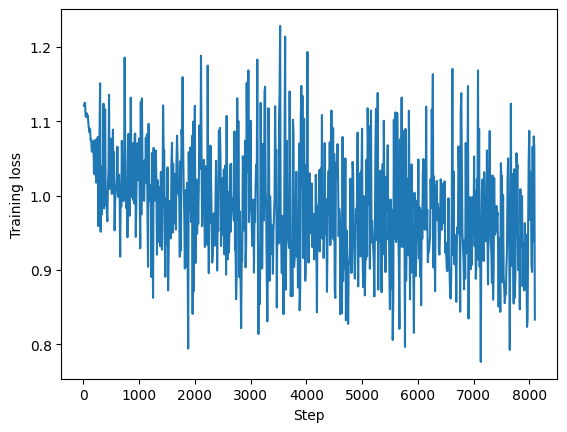

In [ ]:
loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
step = [log['step'] for log in trainer.state.log_history if 'step' in log][:-1]

import matplotlib.pyplot as plt
plt.plot(step, loss)
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.show()

In [ ]:
# Empty VRAM
del model
del trainer

# Invoke garbage collector
import gc
gc.collect()
gc.collect()

0

In [ ]:
from transformers import pipeline

model_path = "./fine_tuned_bert_classification"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
classifier = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

tokenizer_kwargs = {'truncation':True,'max_length':256}
outputs = classifier(list(x_test), **tokenizer_kwargs)

from sklearn.metrics import classification_report
y_pred = [int(output['label'][-1]) for output in outputs]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.48      0.58      0.53      1246
           1       0.60      0.39      0.47       538
           2       0.53      0.50      0.52      1217

    accuracy                           0.52      3001
   macro avg       0.54      0.49      0.51      3001
weighted avg       0.52      0.52      0.51      3001



# Finetuning \#2 for aggression classification - plain #2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

filepath_train = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train.csv'
filepath_test = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev.csv'

df_train = pd.read_csv(filepath_train, header=0).dropna()
df_test = pd.read_csv(filepath_test, header=0).dropna()

df_train.head()

,id,text,class
0,facebook_corpus_msr_401470,Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu...,OAG
1,facebook_corpus_msr_386695,Bhai 60sal pehle desh me kya tha pehle pta kro...,CAG
2,facebook_corpus_msr_373389,chutiya friday ko isliye releae krte kyoki wee...,CAG
3,facebook_corpus_msr_917635,जय मोदीराज,CAG
4,facebook_corpus_msr_382517,UPA walo ne bahot kuch kr diya tha desh k liye,CAG


In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


In [ ]:
aggression_dict = {'CAG':0, 'NAG':1, 'OAG':2}

x_train = df_train['text']
y_train = df_train['class'].apply(lambda key: aggression_dict[key])

# https://datascience.stackexchange.com/a/15136
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify = y_train)

x_test = df_test['text']
y_test = df_test['class'].apply(lambda key: aggression_dict[key])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the tokenizer and model
model_checkpoint = "krishnasri/bert-base-multilingual-uncased-finetuned-hinglish-2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3, from_tf=True)

# Load the tokenizer and model
from datasets import Dataset
def create_dataset(inputs, targets):
    # Throw error if number of comments/tweets is not equal to number of labels
    assert len(inputs) == len(targets)

    # inputs = [input.lower() for input in inputs]
    dataset_dict = {"input_text": inputs, "targets": targets}

    # Create a huggingface dataset from dictionary
    dataset = Dataset.from_dict(dataset_dict)

    # Tokenize the data into 1-hot encoded values for inputs
    def tokenize_and_encode(examples):
        inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        return {"input_ids": inputs.input_ids, "attention_mask": inputs.attention_mask, "labels": examples["targets"]}

    dataset = dataset.map(tokenize_and_encode, batched=True, batch_size=500)
    return dataset

# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    save_steps=1000,                 # number of updates steps before checkpoint saves
    save_total_limit=2,              # limit the total amount of saved checkpoints
    logging_steps=10,                # print losses after 10 steps
)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
train_data = create_dataset(x_train, y_train)
validation_data = create_dataset(x_val, y_val)

trainer = Trainer(
    model=model,                      # the instantiated 🤗 Transformers model to be trained
    args=training_args,               # training arguments, defined above
    train_dataset=train_data,         # training dataset
    eval_dataset=validation_data
)
trainer.train()

# Save the model after training
model_path = "./fine_tuned_bert_classification"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Step,Training Loss
10,1.110700
20,1.115900
30,1.096000
40,1.079800
50,1.051100
60,1.082300
70,1.076700
80,1.067700
90,1.023800
100,1.124100


('./fine_tuned_bert_classification/tokenizer_config.json',
 './fine_tuned_bert_classification/special_tokens_map.json',
 './fine_tuned_bert_classification/vocab.txt',
 './fine_tuned_bert_classification/added_tokens.json',
 './fine_tuned_bert_classification/tokenizer.json')

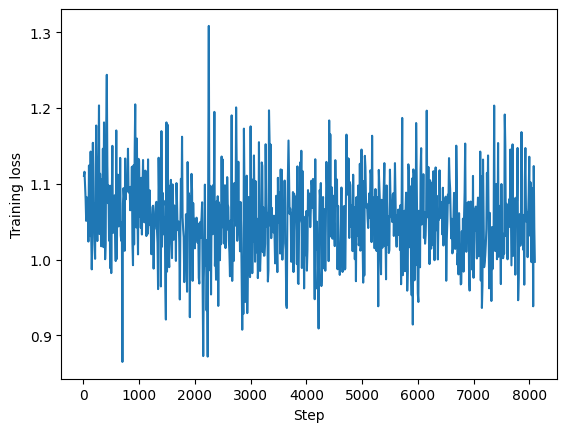

In [ ]:
loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
step = [log['step'] for log in trainer.state.log_history if 'step' in log][:-1]

import matplotlib.pyplot as plt
plt.plot(step, loss)
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.show()

In [ ]:
# Empty VRAM
del model
del trainer

# Invoke garbage collector
import gc
gc.collect()
gc.collect()

0

In [ ]:
from transformers import pipeline

model_path = "./fine_tuned_bert_classification"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
classifier = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

tokenizer_kwargs = {'truncation':True,'max_length':128}
outputs = classifier(list(x_test), **tokenizer_kwargs)

from sklearn.metrics import classification_report
y_pred = [int(output['label'][-1]) for output in outputs]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1246
           1       0.00      0.00      0.00       538
           2       0.41      1.00      0.58      1217

    accuracy                           0.41      3001
   macro avg       0.14      0.33      0.19      3001
weighted avg       0.16      0.41      0.23      3001



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Finetuning \#2 for aggression classification - transliterated

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

filepath_train = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train_translit.csv'
filepath_test = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev_translit.csv'

df_train = pd.read_csv(filepath_train, header=0).dropna()
df_test = pd.read_csv(filepath_test, header=0).dropna()

df_train.head()

,id,text,class
0,facebook_corpus_msr_401470,Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu...,OAG
1,facebook_corpus_msr_386695,Bhai 60sal pehle desh me kya tha pehle pta kro...,CAG
2,facebook_corpus_msr_373389,chutiya friday ko isliye releae krte kyoki wee...,CAG
3,facebook_corpus_msr_917635,jai modiraj,CAG
4,facebook_corpus_msr_382517,UPA walo ne bahot kuch kr diya tha desh k liye,CAG


In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00


In [ ]:
aggression_dict = {'CAG':0, 'NAG':1, 'OAG':2}

x_train = df_train['text']
y_train = df_train['class'].apply(lambda key: aggression_dict[key])

# https://datascience.stackexchange.com/a/15136
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify = y_train)

x_test = df_test['text']
y_test = df_test['class'].apply(lambda key: aggression_dict[key])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the tokenizer and model
model_checkpoint = "krishnasri/bert-base-multilingual-uncased-finetuned-hinglish-2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3, from_tf=True)

# Load the tokenizer and model
from datasets import Dataset
def create_dataset(inputs, targets):
    # Throw error if number of comments/tweets is not equal to number of labels
    assert len(inputs) == len(targets)

    # inputs = [input.lower() for input in inputs]
    dataset_dict = {"input_text": inputs, "targets": targets}

    # Create a huggingface dataset from dictionary
    dataset = Dataset.from_dict(dataset_dict)

    # Tokenize the data into 1-hot encoded values for inputs
    def tokenize_and_encode(examples):
        inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        return {"input_ids": inputs.input_ids, "attention_mask": inputs.attention_mask, "labels": examples["targets"]}

    dataset = dataset.map(tokenize_and_encode, batched=True, batch_size=2)
    return dataset

# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    save_steps=1000,                 # number of updates steps before checkpoint saves
    save_total_limit=2,              # limit the total amount of saved checkpoints
    logging_steps=10,                # print losses after 10 steps
    learning_rate=0.0000005
)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
train_data = create_dataset(x_train, y_train)
validation_data = create_dataset(x_val, y_val)

trainer = Trainer(
    model=model,                      # the instantiated 🤗 Transformers model to be trained
    args=training_args,               # training arguments, defined above
    train_dataset=train_data,         # training dataset
    eval_dataset=validation_data
)
trainer.train()

# Save the model after training
model_path = "./fine_tuned_bert_classification"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Step,Training Loss
10,1.075500
20,1.094700
30,1.088500
40,1.083700
50,1.079000
60,1.092400
70,1.078800
80,1.095700
90,1.102700
100,1.073200


('./fine_tuned_bert_classification/tokenizer_config.json',
 './fine_tuned_bert_classification/special_tokens_map.json',
 './fine_tuned_bert_classification/vocab.txt',
 './fine_tuned_bert_classification/added_tokens.json',
 './fine_tuned_bert_classification/tokenizer.json')

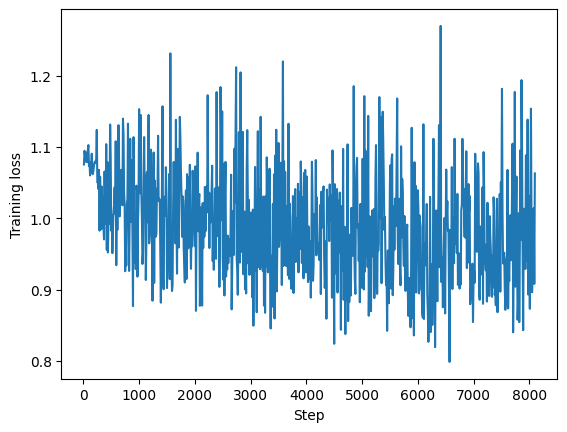

In [ ]:
loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
step = [log['step'] for log in trainer.state.log_history if 'step' in log][:-1]

import matplotlib.pyplot as plt
plt.plot(step, loss)
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.show()

In [ ]:
# Empty VRAM
del model
del trainer

# Invoke garbage collector
import gc
gc.collect()
gc.collect()

0

In [ ]:
from transformers import pipeline

model_path = "./fine_tuned_bert_classification"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
classifier = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

tokenizer_kwargs = {'truncation':True,'max_length':256}
outputs = classifier(list(x_test), **tokenizer_kwargs)

from sklearn.metrics import classification_report
y_pred = [int(output['label'][-1]) for output in outputs]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.49      0.63      0.55      1246
           1       0.61      0.36      0.45       538
           2       0.54      0.47      0.50      1217

    accuracy                           0.52      3001
   macro avg       0.54      0.49      0.50      3001
weighted avg       0.53      0.52      0.51      3001



# Finetuning with MLM objective #3
On TRAC-extended

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [ ]:
import random
import torch
import numpy as np

def set_seed(seed_value=42):
    """Set seed for reproducibility for PyTorch and NumPy.

    Args:
        seed_value (int): The seed value to set for random number generators.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Additional steps for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)  # You can replace 42 with any other seed value of your choice

In [ ]:
from transformers import TFAutoModelForMaskedLM, AutoTokenizer

# Load the tokenizer and model
model_checkpoint = "bert-base-multilingual-uncased"
model = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset
import pandas as pd
import torch

def create_dataset(filepath):
    def tokenize(inputs):
      result = tokenizer(inputs['text'])
      if tokenizer.is_fast:
          result['word_ids'] = [result.word_ids(i) for i in range(len(result['input_ids']))]
      return result

    def group_texts(inputs):
      concatenated = {k: sum(inputs[k], []) for k in inputs.keys()}

      chunk_size = 128
      total_length = len(concatenated[list(inputs.keys())[0]])
      total_length = (total_length // chunk_size) * chunk_size # We drop the last chunk if it's smaller than chunk_size
      result = {
          k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
          for k, t in concatenated.items()
      }

      result['labels'] = result['input_ids'].copy()
      return result

    inputs = pd.read_csv(filepath, header=0, usecols=['text']).dropna()
    input_dataset = Dataset.from_pandas(inputs).train_test_split(test_size=0.1)
    tokenized_dataset = input_dataset.map(tokenize, batched=True, remove_columns=['text', '__index_level_0__'])
    dataset = tokenized_dataset.map(group_texts, batched=True)
    return dataset


hinglish_data = create_dataset("/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train.csv")
hinglish_data

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (656 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4269
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 468
    })
})

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15, return_tensors="tf")

train_dataset = model.prepare_tf_dataset(
    hinglish_data["train"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)

test_dataset = model.prepare_tf_dataset(
    hinglish_data["test"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=32,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import create_optimizer
from transformers.keras_callbacks import PushToHubCallback
import tensorflow as tf
import math

num_train_steps = len(train_dataset)
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=1_000,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

callback = PushToHubCallback(
    output_dir="bert-base-multilingual-uncased-finetuned-hinglish-3", tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/krishnasri/bert-base-multilingual-uncased-finetuned-hinglish-3 into local empty directory.


In [ ]:
model.fit(train_dataset, validation_data=test_dataset, callbacks=[callback])

eval_loss = model.evaluate(test_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

15/15 [==============================] - 9s 566ms/step - loss: 3.6790
Perplexity: 39.61


In [ ]:
from datasets import concatenate_datasets

def create_dataset(filepath):
    def tokenize(inputs):
      result = tokenizer(inputs['text'])
      if tokenizer.is_fast:
          result['word_ids'] = [result.word_ids(i) for i in range(len(result['input_ids']))]
      return result

    def group_texts(inputs):
      concatenated = {k: sum(inputs[k], []) for k in inputs.keys()}

      chunk_size = 128
      total_length = len(concatenated[list(inputs.keys())[0]])
      total_length = (total_length // chunk_size) * chunk_size # We drop the last chunk if it's smaller than chunk_size
      result = {
          k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
          for k, t in concatenated.items()
      }

      result['labels'] = result['input_ids'].copy()
      return result

    inputs = pd.read_csv(filepath, header=0, usecols=['text']).dropna()
    input_dataset = Dataset.from_pandas(inputs).train_test_split(test_size=0.1)
    tokenized_dataset = input_dataset.map(tokenize, batched=True, remove_columns=['text'])
    dataset = tokenized_dataset.map(group_texts, batched=True)
    return dataset

test_translit_dataset = create_dataset("/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev_translit.csv")
test_translit_dataset = concatenate_datasets([test_translit_dataset["train"], test_translit_dataset["test"]])

test_translit_dataset = model.prepare_tf_dataset(
    test_translit_dataset,
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)

eval_loss = model.evaluate(test_translit_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

37/37 [==============================] - 23s 607ms/step - loss: 4.5999
Perplexity: 99.48


In [ ]:
test_plain_dataset = create_dataset("/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev.csv")
test_plain_dataset = concatenate_datasets([test_plain_dataset["train"], test_plain_dataset["test"]])

test_plain_dataset = model.prepare_tf_dataset(
    test_plain_dataset,
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)

eval_loss = model.evaluate(test_plain_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

37/37 [==============================] - 21s 565ms/step - loss: 3.6442
Perplexity: 38.25


# Finetuning \#3 for aggression classification - plain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

filepath_train = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train.csv'
filepath_test = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev.csv'

df_train = pd.read_csv(filepath_train, header=0).dropna()
df_test = pd.read_csv(filepath_test, header=0).dropna()

df_train.head()

,id,text,class
0,facebook_corpus_msr_401470,Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu...,OAG
1,facebook_corpus_msr_386695,Bhai 60sal pehle desh me kya tha pehle pta kro...,CAG
2,facebook_corpus_msr_373389,chutiya friday ko isliye releae krte kyoki wee...,CAG
3,facebook_corpus_msr_917635,जय मोदीराज,CAG
4,facebook_corpus_msr_382517,UPA walo ne bahot kuch kr diya tha desh k liye,CAG


In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
aggression_dict = {'CAG':0, 'NAG':1, 'OAG':2}

x_train = df_train['text']
y_train = df_train['class'].apply(lambda key: aggression_dict[key])

# https://datascience.stackexchange.com/a/15136
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify = y_train)

x_test = df_test['text']
y_test = df_test['class'].apply(lambda key: aggression_dict[key])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the tokenizer and model
model_checkpoint = "krishnasri/bert-base-multilingual-uncased-finetuned-hinglish-3"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3, from_tf=True)

# Load the tokenizer and model
from datasets import Dataset
def create_dataset(inputs, targets):
    # Throw error if number of comments/tweets is not equal to number of labels
    assert len(inputs) == len(targets)

    # inputs = [input.lower() for input in inputs]
    dataset_dict = {"input_text": inputs, "targets": targets}

    # Create a huggingface dataset from dictionary
    dataset = Dataset.from_dict(dataset_dict)

    # Tokenize the data into 1-hot encoded values for inputs
    def tokenize_and_encode(examples):
        inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        return {"input_ids": inputs.input_ids, "attention_mask": inputs.attention_mask, "labels": examples["targets"]}

    dataset = dataset.map(tokenize_and_encode, batched=True, batch_size=2)
    return dataset

# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    save_steps=1000,                 # number of updates steps before checkpoint saves
    save_total_limit=2,              # limit the total amount of saved checkpoints
    logging_steps=10,                # print losses after 10 steps
    learning_rate=0.0000005
)

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/997M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
train_data = create_dataset(x_train, y_train)
validation_data = create_dataset(x_val, y_val)

trainer = Trainer(
    model=model,                      # the instantiated 🤗 Transformers model to be trained
    args=training_args,               # training arguments, defined above
    train_dataset=train_data,         # training dataset
    eval_dataset=validation_data
)
trainer.train()

# Save the model after training
model_path = "./fine_tuned_bert_classification"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Step,Training Loss
10,1.080800
20,1.099700
30,1.095200
40,1.052200
50,1.048500
60,1.090200
70,1.083500
80,1.100400
90,1.098500
100,1.061500


('./fine_tuned_bert_classification/tokenizer_config.json',
 './fine_tuned_bert_classification/special_tokens_map.json',
 './fine_tuned_bert_classification/vocab.txt',
 './fine_tuned_bert_classification/added_tokens.json',
 './fine_tuned_bert_classification/tokenizer.json')

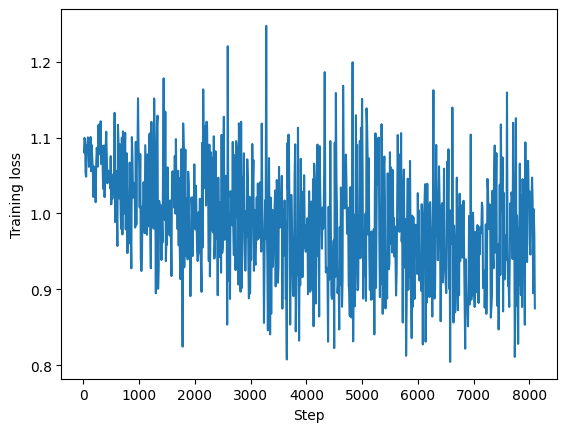

In [ ]:
loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
step = [log['step'] for log in trainer.state.log_history if 'step' in log][:-1]

import matplotlib.pyplot as plt
plt.plot(step, loss)
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.show()

In [ ]:
# Empty VRAM
del model
del trainer

# Invoke garbage collector
import gc
gc.collect()
gc.collect()

0

In [ ]:
from transformers import pipeline

model_path = "./fine_tuned_bert_classification"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
classifier = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

tokenizer_kwargs = {'truncation':True,'max_length':256}
outputs = classifier(list(x_test), **tokenizer_kwargs)

from sklearn.metrics import classification_report
y_pred = [int(output['label'][-1]) for output in outputs]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.49      0.63      0.55      1246
           1       0.66      0.36      0.46       538
           2       0.54      0.48      0.51      1217

    accuracy                           0.52      3001
   macro avg       0.56      0.49      0.51      3001
weighted avg       0.54      0.52      0.52      3001



# Finetuning \#3 for aggression classification - transliterated

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

filepath_train = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_train_translit.csv'
filepath_test = '/content/drive/MyDrive/Colab Notebooks/NLP Project/data_nlp/agr_hi_dev_translit.csv'

df_train = pd.read_csv(filepath_train, header=0).dropna()
df_test = pd.read_csv(filepath_test, header=0).dropna()

df_train.head()

,id,text,class
0,facebook_corpus_msr_401470,Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu...,OAG
1,facebook_corpus_msr_386695,Bhai 60sal pehle desh me kya tha pehle pta kro...,CAG
2,facebook_corpus_msr_373389,chutiya friday ko isliye releae krte kyoki wee...,CAG
3,facebook_corpus_msr_917635,jai modiraj,CAG
4,facebook_corpus_msr_382517,UPA walo ne bahot kuch kr diya tha desh k liye,CAG


In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00


In [ ]:
aggression_dict = {'CAG':0, 'NAG':1, 'OAG':2}

x_train = df_train['text']
y_train = df_train['class'].apply(lambda key: aggression_dict[key])

# https://datascience.stackexchange.com/a/15136
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify = y_train)

x_test = df_test['text']
y_test = df_test['class'].apply(lambda key: aggression_dict[key])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the tokenizer and model
model_checkpoint = "krishnasri/bert-base-multilingual-uncased-finetuned-hinglish-3"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3, from_tf=True)

# Load the tokenizer and model
from datasets import Dataset
def create_dataset(inputs, targets):
    # Throw error if number of comments/tweets is not equal to number of labels
    assert len(inputs) == len(targets)

    # inputs = [input.lower() for input in inputs]
    dataset_dict = {"input_text": inputs, "targets": targets}

    # Create a huggingface dataset from dictionary
    dataset = Dataset.from_dict(dataset_dict)

    # Tokenize the data into 1-hot encoded values for inputs
    def tokenize_and_encode(examples):
        inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        return {"input_ids": inputs.input_ids, "attention_mask": inputs.attention_mask, "labels": examples["targets"]}

    dataset = dataset.map(tokenize_and_encode, batched=True, batch_size=2)
    return dataset

# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    save_steps=1000,                 # number of updates steps before checkpoint saves
    save_total_limit=2,              # limit the total amount of saved checkpoints
    logging_steps=10,                # print losses after 10 steps
    learning_rate=0.0000005
)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
train_data = create_dataset(x_train, y_train)
validation_data = create_dataset(x_val, y_val)

trainer = Trainer(
    model=model,                      # the instantiated 🤗 Transformers model to be trained
    args=training_args,               # training arguments, defined above
    train_dataset=train_data,         # training dataset
    eval_dataset=validation_data
)
trainer.train()

# Save the model after training
model_path = "./fine_tuned_bert_classification"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Map:   0%|          | 0/10799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Step,Training Loss
10,1.075100
20,1.094300
30,1.088200
40,1.083600
50,1.078700
60,1.092100
70,1.078400
80,1.095600
90,1.102400
100,1.072800


('./fine_tuned_bert_classification/tokenizer_config.json',
 './fine_tuned_bert_classification/special_tokens_map.json',
 './fine_tuned_bert_classification/vocab.txt',
 './fine_tuned_bert_classification/added_tokens.json',
 './fine_tuned_bert_classification/tokenizer.json')

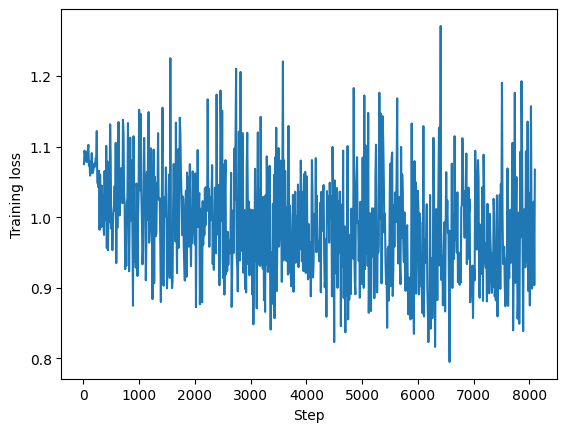

In [ ]:
loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
step = [log['step'] for log in trainer.state.log_history if 'step' in log][:-1]

import matplotlib.pyplot as plt
plt.plot(step, loss)
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.show()

In [ ]:
# Empty VRAM
del model
del trainer

# Invoke garbage collector
import gc
gc.collect()
gc.collect()

0

In [ ]:
from transformers import pipeline

model_path = "./fine_tuned_bert_classification"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
classifier = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

tokenizer_kwargs = {'truncation':True,'max_length':256}
outputs = classifier(list(x_test), **tokenizer_kwargs)

from sklearn.metrics import classification_report
y_pred = [int(output['label'][-1]) for output in outputs]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.49      0.63      0.55      1246
           1       0.60      0.36      0.45       538
           2       0.53      0.46      0.49      1217

    accuracy                           0.51      3001
   macro avg       0.54      0.48      0.50      3001
weighted avg       0.52      0.51      0.51      3001

